http://mlwiki.org/index.php/Cost-Complexity_Pruning<br>
Полезно и коротко описаны алгоритмы и все для ML!

In [59]:
import numpy as np

In [60]:
#a = np.array( [0.1, 0.05, 0.3, 0.15, 0.4] ) 
#a = np.array( [0.3, 0.2, 0.5] )  
#a = np.array( [0.5, 0.5] )
a = np.array( [1] )

# формула для энтропии Шеннона https://habr.com/ru/post/305794/
H = -1*np.sum( list(map(lambda x: x*np.log2(x), a)) )
a, H
# (array([0.1 , 0.05, 0.3 , 0.15, 0.4 ]), 2.0086949695628418)
# (array([0.3, 0.2, 0.5]), 1.4854752972273344)
# (array([0.5, 0.5]), 1.0)
# (array([1]), -0.0)

(array([1]), -0.0)

__https://habr.com/ru/post/305794/__<br>
$H = -\sum_{i} {P_{i}*log_2P_i}$<br>
энтропия напрямую связана с «неожиданностью» возникновения события. А отсюда вытекает и его информативность — чем событие более предсказуемо, тем оно менее информативно.<br>

https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F
<br>__Информацио́нная энтропи́я__ — мера неопределённости некоторой системы (в статистической физике или теории информации), в частности непредсказуемость появления какого-либо символа первичного алфавита. В последнем случае при отсутствии информационных потерь энтропия численно равна<br>
количеству информации на символ передаваемого сообщения. 


In [61]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [62]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction                
        

In [90]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества
def quality(left_labels, right_labels, current_gini):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле
def split(data, labels, index, t):  
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]       
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения
def find_best_split(data, labels):  
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


def classify_object(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
    
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes        

# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [91]:
#########################################################################
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(
    n_samples=50,
    n_features=2,
    n_informative=2, 
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.75,
    random_state=100
)

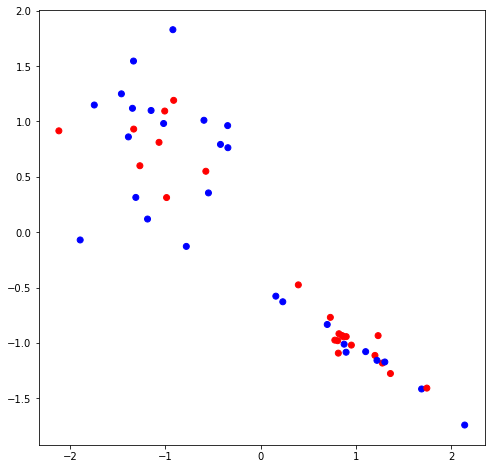

In [92]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [93]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, classification_labels, test_size = 0.3, random_state = 1
)

In [94]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [95]:
print_tree(my_tree)

Индекс 0
Порог 0.6990708283915846
--> True:
  Индекс 0
  Порог -0.9125152444311508
  --> True:
    Индекс 0
    Порог -1.3449423536879115
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 0
  --> False:
    Прогноз: 1
--> False:
  Индекс 0
  Порог 0.8684661215869487
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 1


In [96]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [97]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [98]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)

train_accuracy, test_accuracy

(80.0, 40.0)

Text(0.5, 1.0, 'Test accuracy=40.00')

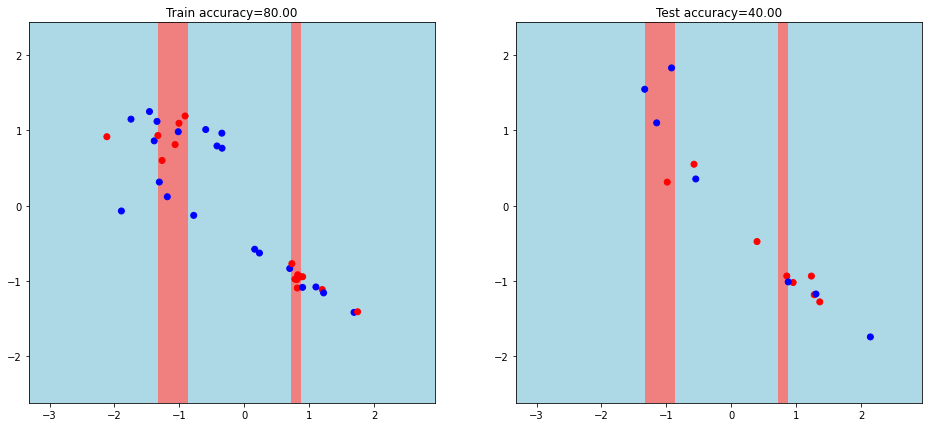

In [99]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, shading='auto', cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, shading='auto', cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [100]:
np.mean(test_labels)

0.4666666666666667

__1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).__

In [101]:
# Нахождение наилучшего разбиения
def find_best_split_v2(data, labels, features_list, min_leaf = 5 ):  
    #  обозначим минимальное количество объектов в узле
    #min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    for index in features_list:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


def build_tree_v2(data, labels, features_list, depth = 0, max_depth = 10, min_leaf = 5 ):
    quality, t, index = find_best_split_v2(data, labels, features_list, min_leaf)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    if depth >= max_depth:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    depth += 1
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, depth)
    false_branch = build_tree(false_data, false_labels, depth)
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)



__2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.__

Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$:<br>
$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$<br>
$p_{k}$ будет характеризовать вероятность выдачи класса $k$.<br>
Еще один критерий информативности - _энтропийный критерий_. Он также называется _энтропией Шеннона_ и записывается как<br>
$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$<br>
Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Стоит отметить, что в формуле полагается, что $0\text{log}_{2}0=0.$

In [102]:
def user_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    print(f'classes: {classes}')
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)        
        impurity -= p*np.log2(p)
        print(f'p[{label}]: {p}, impur: {impurity}')

    return impurity

# Нахождение наилучшего разбиения
def find_best_split_entropy(data, labels):  
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = user_entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

def build_tree_entropy(data, labels):
    quality, t, index = find_best_split_entropy(data, labels)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [103]:
#########################################################################
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(
    n_samples=100,
    n_features=3,
    n_informative=2, 
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.25,
    random_state=100
)

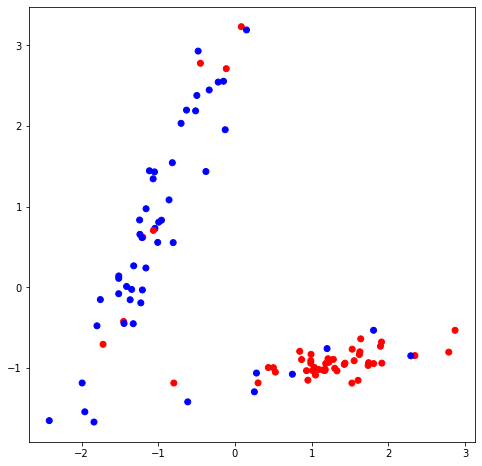

In [104]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [105]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, classification_labels, test_size = 0.3, random_state = 1
)

In [106]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)
my_tree_entropy = build_tree_entropy(train_data, train_labels)


classes: {0: 37, 1: 33}
p[0]: 0.5285714285714286, impur: 0.486195672838466
p[1]: 0.4714285714285714, impur: 0.9976432959863936


In [107]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)

train_accuracy, test_accuracy

(90.0, 80.0)

In [108]:
# Получим ответы для обучающей выборки 
train_answers_e = predict(train_data, my_tree_entropy)
# И получим ответы для тестовой выборки
answers_e = predict(test_data, my_tree_entropy)
# Точность на обучающей выборке
train_accuracy_e = accuracy_metric(train_labels, train_answers_e)
# Точность на тестовой выборке
test_accuracy_e = accuracy_metric(test_labels, answers_e)

train_accuracy_e, test_accuracy_e

(90.0, 80.0)

__Вывод:__ Оценки получены одинаковые, вероятно поэтому изза простоты вычислений используется критерий джини.   

__________________________________

__3 [опция]. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.__

In [ ]:
# дерево для задачи регрессии, класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# дерево для задачи регрессии, класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    #заменив механизм предсказания в листе на взятие среднего значения по выборке
    def predict(self):        
        prediction = np.mean(self.labels)
        return prediction                

# Расчет критерия Джини -> на дисперсию значений
def gini(labels):
    sigma = np.mean( (labels - np.mean(labels))**2 )
    return sigma